# PyTorch Tensor로 데이터 로딩

In [2]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('./data/train/',simple_transform)
valid = ImageFolder('./data/valid/',simple_transform)

In [11]:
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


In [3]:
# 데이터 확인하기 위해서
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

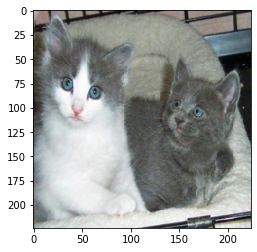

In [17]:
imshow(valid[770][0])

# 데이터 제너레이터 생성

In [18]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=16,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=16,num_workers=3,shuffle=True)

# VGG16 모델 생성과 탐색

In [8]:
from torchvision import models
vgg = models.vgg16(pretrained=True) # 전이 학습을 할 것이므로 pre-training된 vgg16모델을 사용할 것

vgg16 모델을 print해보면 다음과 같이 features와 classifier로 구성됨을 알 수 있다.

**이 때, features 순차 모델에 포함된 레이어의 학습 파라미터는 전이 학습 과정에서 고정될 것이다.**

In [2]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 레이어 고정

features 모델에는 미리 학습된(pretrained) 가중치를 가지는 컨볼루션 블록이 포함돼 있다.

레이어에서 가중치를 고정하는 설정을 통해 Convolution 블록의 학습 파라미터가 더는 학습되지 않도록 보호한다.

다음의 코드는 옵티마이저가 가중치를 업데이트하지 못하도록 한다.

In [11]:
for param in vgg.features.parameters():
    param.requires_grad = False

# 세부 조정: VGG16

VGG16 모델은 1000개 카테고리를 분류하도록 학습되어 있다.

따라서 개와 고양이를 분류하도록 훈련시키기 위해서는 마지막 레이어의 출력을 1000에서 2로 바꾸어야 한다.

In [12]:
vgg.classifier[6].out_features = 2

vgg.classifier는 순차 모델 내부의 모든 레이어에 대한 접근을 허용한다.

vgg.classifier는 6개의 요소로 구성돼 있다. (위의 print(vgg)의 결과를 참고할 것)

**VGG16 모델을 전이 학습시킬 때, classifier 내부 요소만을 학습시킬 것이다.**

따라서 다음과 같이 classifier.parameters를 옵티마이저에 전달한다.

In [14]:
import torch

optimizer = torch.optim.SGD(vgg.classifier.parameters(), lr=0.0001, momentum=0.5)
# 아직 momentum을 0.5로 설정하는지에 대해서는 모르겠음...

# VGG 모델 학습



In [17]:
import torch.nn.functional as F
from torch.autograd import Variable

if torch.cuda.is_available():
    vgg = vgg.cuda() # 모델을 cuda로 바꿔줘야함!!

def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if torch.cuda.is_available():
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output,target) # Cross-entropy Loss : 이진 분류와 다중 분류 문제에서 사용되는 오차 함수
        
        running_loss += F.cross_entropy(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss.item() /len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [26]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,10):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   1.7 and training accuracy is 17886/23000     77.77
validation loss is 0.085 and validation accuracy is 1950/2000      97.5
training loss is   0.1 and training accuracy is 22287/23000      96.9
validation loss is 0.058 and validation accuracy is 1962/2000      98.1
training loss is 0.075 and training accuracy is 22425/23000      97.5
validation loss is 0.051 and validation accuracy is 1964/2000      98.2
training loss is 0.065 and training accuracy is 22514/23000     97.89
validation loss is 0.047 and validation accuracy is 1967/2000     98.35
training loss is 0.058 and training accuracy is 22531/23000     97.96
validation loss is 0.045 and validation accuracy is 1968/2000      98.4
training loss is 0.054 and training accuracy is 22578/23000     98.17
validation loss is 0.043 and validation accuracy is 1968/2000      98.4
training loss is 0.049 and training accuracy is 22618/23000     98.34
validation loss is 0.042 and validation accuracy is 1969/2000     98.45
traini

# 학습과 검증 오차에 대한 그래프

C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Stud

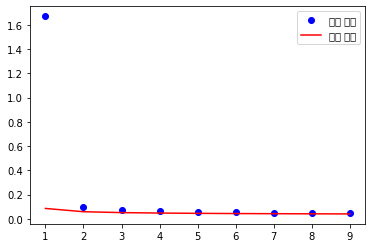

In [29]:
%matplotlib inline

plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label = '학습 오차')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label = '검증 오차')
plt.legend()

# 학습과 검증 정확도에 대한 그래프

C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54869 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tpgns\anaconda3\envs\VGG16_Stud

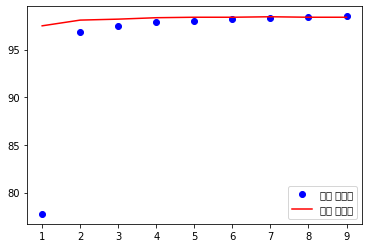

In [30]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo', label = '학습 정확도')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label = '검증 정확도')
plt.legend()

# 드롭아웃 비율 변경을 통한 성능 개선

드롭아웃을 다음 코드처럼 0.5에서 0.2로 변경하면 3에폭 학습만을 통해 성능 개선을 할 수 있다.

In [32]:
import torch.nn as nn

for layer in vgg.classifier.children():
    if(type(layer) == nn.Dropout):
        layer.p = 0.2

In [33]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,4):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is 0.034 and training accuracy is 22742/23000     98.88
validation loss is  0.04 and validation accuracy is 1969/2000     98.45
training loss is 0.032 and training accuracy is 22744/23000     98.89
validation loss is 0.039 and validation accuracy is 1969/2000     98.45
training loss is  0.03 and training accuracy is 22750/23000     98.91
validation loss is 0.039 and validation accuracy is 1968/2000      98.4
Wall time: 8min 40s


# 데이터 증식을 통한 성능 개선

모델의 일반화 성능을 개선하는 방법에는 더 많은 데이터를 수집하는 방법과 데이터를 증식하는 방법이 있다.

이번에는 데이터 증식을 통해 성능을 개선해보자.

다음 코드는 이미지를 수평으로 뒤집거나 작은 각도로 이미지를 회전해 데이터 증식을 한 후에 학습시키는 코드이다.

In [4]:
train_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.RandomHorizontalFlip()
                                       ,transforms.RandomRotation(0.2)
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('./data/train/',train_transform)
valid = ImageFolder('./data/valid/',simple_transform)

In [9]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [15]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,3):
    epoch_loss, epoch_accuracy = fit(epoch,vgg,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,vgg,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    
# 아래 실행 결과는 내 노트북의 GPU 메모리가 부족해서 그런 것이니 신경쓰지 말것!

C:\Users\tpgns\anaconda3\envs\VGG16_Study\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is   3.2 and training accuracy is 13741/23000     59.74


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 6.00 GiB total capacity; 4.02 GiB already allocated; 200.91 MiB free; 4.13 GiB reserved in total by PyTorch)

# 학습 속도 향상 시키기

위의 코드들은 GPU를 사용해 학습할 경우에 1에폭을 학습하는 데 2분 이상의 시간이 걸린다.

이를 해결해보자.

우선, 컨볼루션 레이어의 학습 파라미터를 고정하고 모델을 학습할 때, features의 계산 결과는 항상 같은 값이므로 classifier의 입력에는 항상 같은 값이 입력된다.

따라서 classifier의 입력 데이터에 features의 계산 결과를 저장하고 재사용하면, 학습 속도를 높일 수 있다.

In [16]:
vgg = models.vgg16(pretrained=True)

if torch.cuda.is_available():
    vgg = vgg.cuda()


RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 6.00 GiB total capacity; 4.08 GiB already allocated; 200.91 MiB free; 4.13 GiB reserved in total by PyTorch)

In [18]:
features = vgg.features

In [19]:
for param in features.parameters(): param.requires_grad = False

In [20]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=False)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=False)

In [21]:
def preconvfeat(dataset,model):
    conv_features = []
    labels_list = []
    for data in dataset:
        inputs,labels = data
        if torch.cuda.is_available():
            inputs , labels = inputs.cuda(), labels.cuda()       
        inputs , labels = Variable(inputs), Variable(labels)
        output = model(inputs)
        conv_features.extend(output.data.cpu().numpy()) # extend 함수는 append와 비슷하지만 iterable에서 원소들만 저장함
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    
    return (conv_features,labels_list)

In [22]:
conv_feat_train,labels_train = preconvfeat(train_data_loader,features)

In [23]:
conv_feat_val,labels_val = preconvfeat(valid_data_loader,features)

다음으로 컨볼루션 연산 결과를 통해 새로운 Dataset 클래스를 생성한다.

그 후에 이 클래스를 이용해 DataLoader 객체를 생성한다.

In [28]:
from torch.utils.data import Dataset, DataLoader

class My_dataset(Dataset):
    def __init__(self,feat,labels):
        self.conv_feat = feat
        self.labels = labels
    
    def __len__(self):
        return len(self.conv_feat)
    
    def __getitem__(self,idx):
        return self.conv_feat[idx],self.labels[idx]

In [29]:
train_feat_dataset = My_dataset(conv_feat_train,labels_train)
val_feat_dataset = My_dataset(conv_feat_val,labels_val)

In [30]:
train_feat_loader = DataLoader(train_feat_dataset,batch_size=64,shuffle=True)
val_feat_loader = DataLoader(val_feat_dataset,batch_size=64,shuffle=True)

In [31]:
def data_gen(conv_feat,labels,batch_size=64,shuffle=True):
    labels = np.array(labels)
    if shuffle:
        index = np.random.permutation(len(conv_feat))
        conv_feat = conv_feat[index]
        labels = labels[index]
    for idx in range(0,len(conv_feat),batch_size):
        yield(conv_feat[idx:idx+batch_size],labels[idx:idx+batch_size])

In [32]:
train_batches = data_gen(conv_feat_train,labels_train)
val_batches = data_gen(conv_feat_val,labels_val)

In [34]:
optimizer = torch.optim.SGD(vgg.classifier.parameters(),lr=0.0001,momentum=0.5)

In [37]:
def fit_numpy(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if torch.cuda.is_available():
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        data = data.view(data.size(0), -1)
        output = model(data)
        loss = F.cross_entropy(output,target)
        
        running_loss += F.cross_entropy(output,target,size_average=False).data[0]
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [38]:
%%time
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit_numpy(epoch,vgg.classifier,train_feat_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit_numpy(epoch,vgg.classifier,val_feat_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

IndexError: invalid index of a 0-dim tensor. Use tensor.item() to convert a 0-dim tensor to a Python number

# 모델에서 특정 레이어의 가중치를 얻는 방법

모든 모델 가중치는 state_dict 함수를 통해 액세스할 수 있다.

state_dict 함수는 딕셔너리 객체를 반환한다.

이 반환 객체로부터 레이어명을 키로 해 가중치를 조회할 수 있다.

In [39]:
vgg.state_dict().keys()
cnn_weights = vgg.state_dict()['features.0.weight'].cpu()

IndexError: index 3 is out of bounds for dimension 0 with size 3

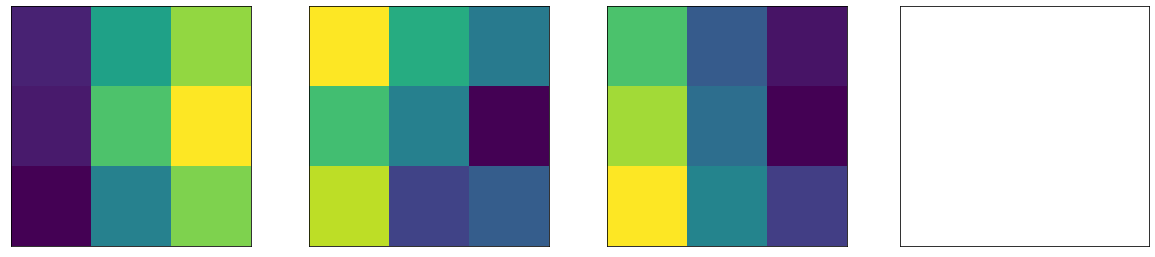

In [41]:
fig = plt.figure(figsize=(20, 50))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0, wspace=0.2)
for i in range(30):
    ax = fig.add_subplot(12,5,i+1,xticks=[],yticks=[])
    ax.imshow(cnn_weights[0][i])